## Аминокислотные последовательности антител

<img src="https://i0.wp.com/www.blopig.com/blog/wp-content/uploads/2013/07/Antibody1.png?ssl=1" style="background:white" width="600"/>

Как и любые белки́, [антитела](https://ru.wikipedia.org/wiki/%D0%90%D0%BD%D1%82%D0%B8%D1%82%D0%B5%D0%BB%D0%B0) состоят из [аминокислот](https://shorturl.at/Wc6V4), соединённых пептидными связями.

Каждой аминокислоте соответствует однобуквенный код (A - аланин, C - цистеин, D - аспартат, и т.д.), поэтому мы можем компактно записывать первичную структуру белков (то есть просто цепочку аминокислот) в виде строк.

Сегодня нам предстоит решить две задачи:
1. Обучить модель-классификатор, позволяющую по аминокислотной последовательности понять, из какого животного было получено антитело
2. Обучить модель-генератор новых антител с условием на биологический вид

#### Подготовим данные

В нашем наборе данных присутствуют антитела (точнее - небольшие фрагменты тяжелых цепей антител, VH-домены, непосредственно участвующие в связывании инородных молекул - антигенов), полученные из образцов пяти биологических видов: человек, макака-резус, мышь, кролик и верблюд.

In [160]:
import pandas as pd

antibodies = pd.read_csv("../datasets/antibodies.csv").sample(frac=1.0)
antibodies.head(10)

,sequence,species
1615,HVQLVESGGGSVEAGGSLRLSCAASGFTFGSYYMSWVRQAPGKGLE...,Camel
2649,SVKVSCKASGGTFSTFAFSWVRQAPGQGLEWMGGVTPVFRTANYAQ...,Mouse
44,QIQLVQSGPELKKPGETVKISCKASGYTFTEYPMHWVKQAPGTGFK...,Human
3713,QVQLQESGPGLVKPSQTLSLSCAISGDSVSNNSTTWNWIRQSPSRG...,Rhesus
4371,QQQLEESGGGLVKPGGTLTLTCTASGFSFSSSYYMCWVRQAPGKGL...,Rabbit
1834,ESGGGSVQPGGSLRLSCASSGYTANSGCMGWFRQTPGKEREAVAVV...,Camel
2638,SVKVSCKASGYTFTNYFMHWLRQAPGQGLEWMGIINPSGGNTNYAK...,Mouse
1641,HVQLVESGGDSVQAGGSLRLSCAASGYTYSSNCMGWFRQAPGKARE...,Camel
842,EVQLQQSGPELVKPGASVKISCKASGYTFTDYYMNWVKQSHGKSLE...,Human
2408,SVKVSCKASGGTFSNYGISWVRQAPGQGLEWVGGIIPISATTNYAQ...,Mouse


Создадим словари для аминокислот, специальных токенов и биологических видов:

In [161]:
SPECIAL_TOKENS = "_?\n"
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWYX"
VOCAB = {char: i for i, char in enumerate(SPECIAL_TOKENS + AMINO_ACIDS)}
SPECIES = {name: i for i, name in enumerate(sorted(antibodies["species"].unique()))}
SPECIES

{'Camel': 0, 'Human': 1, 'Mouse': 2, 'Rabbit': 3, 'Rhesus': 4}

In [162]:
import torch
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split


class AntibodiesDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.sequences = [
            [1] + [VOCAB[char] for char in s] + [2] for s in df["sequence"]
        ]
        self.labels = [SPECIES[label] for label in df["species"]]

    def __getitem__(self, index: int) -> tuple[list[int], int]:
        return self.sequences[index], self.labels[index]

    def __len__(self) -> int:
        return len(self.sequences)

    @staticmethod
    def collate_fn(batch: list[tuple[list[int], int]]) -> tuple[Tensor, Tensor]:
        encoded, lang_ids = zip(*batch)
        max_len = max(map(len, encoded))
        x = torch.zeros((len(encoded), max_len), dtype=int)
        for i, seq in enumerate(encoded):
            x[i, : len(seq)] = torch.tensor(seq)

        return x, torch.tensor(list(lang_ids))


labels = sorted(antibodies["species"].unique())
dataset = AntibodiesDataset(antibodies)
train_dataset, test_dataset = random_split(
    dataset, [4500, 500], torch.Generator().manual_seed(42)
)
print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))

Train size:  4500
Test size:  500


In [163]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=dataset.collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=dataset.collate_fn
)

#### Задание 1 (6 баллов). Классификация антител по биологическим видам

Мы начнём с нашей рекуррентной ячейки с последней практики:

In [164]:
class RNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """

    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim + hidden_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim
        # h: B x hidden_dim
        h = torch.cat([x, h], dim=1)
        h = self.linear(h)
        return F.tanh(h)

In [8]:
class GRUCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """

    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.W = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.Wz = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.Wr = nn.Linear(input_dim + hidden_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim
        # h: B x hidden_dim
        z_t = F.sigmoid(self.Wz(torch.cat([h, x], dim=1)))
        r_t = F.sigmoid(self.Wr(torch.cat([h, x], dim=1)))
        h_hat = F.tanh(self.W(torch.cat([r_t * h, x], dim=1)))
        return (1 - z_t) * h + z_t * h_hat

**1.1. (1 балл)** Реализуйте архитектуру модели, которая по входной последовательности будет давать вероятностное распределение над биологическими видами.
Она даже немного проще, чем модель для генерации: линейный блок-классификатор мы применяем только к последнему скрытому состоянию (когда вся последовательность обработана).

**1.2. (2 балла)** Обучите модель в течение 10-50 эпох, постройте графики точности классифкации для обучающей и тестовой выборок.

**1.3. (3 балла)** Реализуйте другой вид рекуррентной ячейки (GRU или LSTM, см. практику), обучите модель на его основе, выведите графики точности. Как изменилась точность модели и скорость обучения?


Указание: используйте небольшие модели, с размером скрытого слоя 64

In [165]:

class RNN(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int = 64, n_classes: int = 5, cell: nn.Module = RNNCell) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = cell(hidden_dim, hidden_dim)
        self.lm_head = nn.Linear(hidden_dim, n_classes)


    def forward(self, x: Tensor) -> Tensor:
        # x: B x T
        # embed(x): B x T -> B x T x hidden_dim
        B, T = x.shape

        x = self.embed(x)  # B x T x hidden_dim
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn.forward(xt, h)  # B x hidden

        return self.lm_head(h) # B x n_classes



In [166]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [170]:
def train_epoch(dataloader: DataLoader,model: nn.Module,optimizer: torch.optim.Optimizer):
    model.train()
    loss_total = 0
    n_correct = 0
    n_total = 0

    for tokens, labels in train_loader:
        logits = model(tokens.to(device))  
        loss = F.cross_entropy(logits, labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        n_total += labels.size(0)
        n_correct += (labels.to(device) == logits.argmax(dim=1)).sum().item()
        loss_total += labels.size(0) * loss.item()
        
    loss=loss_total / n_total
    acc = n_correct / n_total
    
    train_loss.append(loss)
    train_acc.append(acc)

In [171]:
@torch.no_grad()
def test_epoch(dataloader: DataLoader,model: nn.Module):
    model.eval()
    loss_total = 0
    n_correct = 0
    n_total = 0

    for tokens, labels in train_loader:
        logits = model(tokens.to(device))  
        loss = F.cross_entropy(logits, labels.to(device))
        n_total += labels.size(0)
        n_correct += (labels.to(device) == logits.argmax(dim=1)).sum().item()
        loss_total += labels.size(0) * loss.item()
    
    loss=loss_total / n_total
    acc = n_correct / n_total
    
    val_loss.append(loss)
    val_acc.append(acc)

In [172]:
torch.manual_seed(42)
model = RNN(vocab_size=len(VOCAB)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 15
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(EPOCHS):
    print(f"EPOCH {epoch}")
    train_epoch(train_loader,model,optimizer) 
    test_epoch(test_loader,model)    
    print(f"Train: loss={train_loss[-1]:.5f}, accuracy={train_acc[-1]:.5f}; Val: loss={val_loss[-1]:.5f}, accuracy={val_acc[-1]:.5f}")
    
    

EPOCH 0
Train: loss=1.51748, accuracy=0.30000; Val: loss=1.53020, accuracy=0.26089
EPOCH 1
Train: loss=1.32377, accuracy=0.41333; Val: loss=1.27310, accuracy=0.43467
EPOCH 2
Train: loss=1.37121, accuracy=0.40156; Val: loss=1.34800, accuracy=0.43778
EPOCH 3
Train: loss=1.27665, accuracy=0.43911; Val: loss=1.39362, accuracy=0.40244
EPOCH 4
Train: loss=1.27531, accuracy=0.42222; Val: loss=1.22981, accuracy=0.44978
EPOCH 5
Train: loss=1.25269, accuracy=0.43178; Val: loss=1.25158, accuracy=0.43733
EPOCH 6
Train: loss=1.27837, accuracy=0.42022; Val: loss=1.24687, accuracy=0.44044
EPOCH 7
Train: loss=1.24656, accuracy=0.44356; Val: loss=1.21657, accuracy=0.45111
EPOCH 8
Train: loss=1.22532, accuracy=0.44689; Val: loss=1.25067, accuracy=0.43178
EPOCH 9
Train: loss=1.21774, accuracy=0.44667; Val: loss=1.21625, accuracy=0.44622
EPOCH 10
Train: loss=1.21684, accuracy=0.45111; Val: loss=1.26321, accuracy=0.43733
EPOCH 11
Train: loss=1.22815, accuracy=0.42956; Val: loss=1.24099, accuracy=0.44200
EP

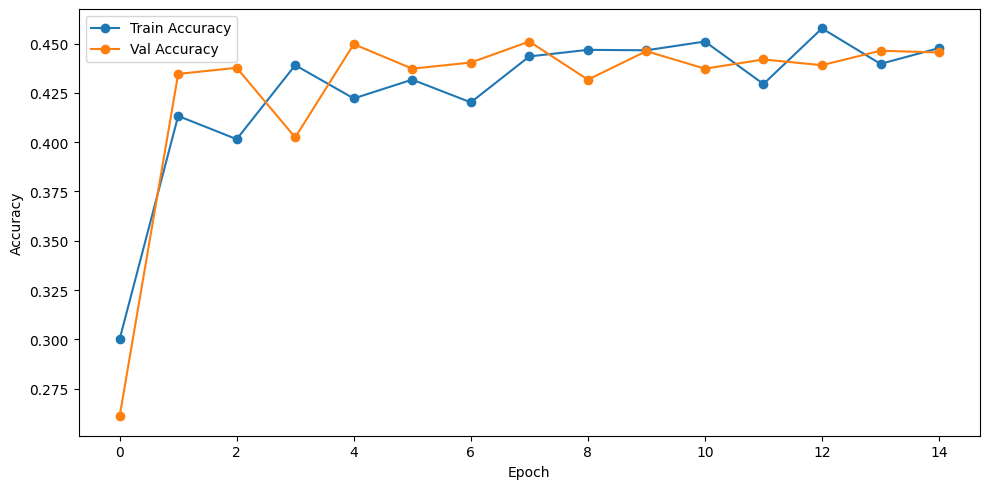

In [173]:
import matplotlib.pyplot as plt

def grafics(train_acc, val_acc, conf):
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label=f"Train {conf}", marker='o')
    plt.plot(val_acc, label=f"Val {conf}", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel(conf)
    plt.legend()
    plt.tight_layout()
    plt.show()  
    
grafics(train_acc,val_acc, "Accuracy")

In [174]:
torch.manual_seed(42)
model = RNN(vocab_size=len(VOCAB), cell = GRUCell).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 15
train_loss = []
train_acc = []
val_loss = []
val_acc = []


for epoch in range(EPOCHS):
    print(f"EPOCH {epoch}")
    train_epoch(train_loader,model,optimizer) 
    test_epoch(train_loader,model)    
    print(f"Train: loss={train_loss[-1]:.5f}, accuracy={train_acc[-1]:.5f}; Val: loss={val_loss[-1]:.5f}, accuracy={val_acc[-1]:.5f}")

EPOCH 0
Train: loss=1.30375, accuracy=0.43889; Val: loss=0.88964, accuracy=0.74178
EPOCH 1
Train: loss=0.50976, accuracy=0.84467; Val: loss=0.22959, accuracy=0.92978
EPOCH 2
Train: loss=0.16609, accuracy=0.94889; Val: loss=0.11484, accuracy=0.96111
EPOCH 3
Train: loss=0.10286, accuracy=0.96844; Val: loss=0.06752, accuracy=0.98200
EPOCH 4
Train: loss=0.06669, accuracy=0.97844; Val: loss=0.12385, accuracy=0.95511
EPOCH 5
Train: loss=0.05175, accuracy=0.98311; Val: loss=0.03288, accuracy=0.99044
EPOCH 6
Train: loss=0.03769, accuracy=0.98889; Val: loss=0.02891, accuracy=0.99200
EPOCH 7
Train: loss=0.03492, accuracy=0.98867; Val: loss=0.02425, accuracy=0.99267
EPOCH 8
Train: loss=0.02810, accuracy=0.99222; Val: loss=0.02481, accuracy=0.99133
EPOCH 9
Train: loss=0.02609, accuracy=0.99200; Val: loss=0.01970, accuracy=0.99378
EPOCH 10
Train: loss=0.02085, accuracy=0.99422; Val: loss=0.01749, accuracy=0.99489
EPOCH 11
Train: loss=0.02363, accuracy=0.99267; Val: loss=0.01416, accuracy=0.99600
EP

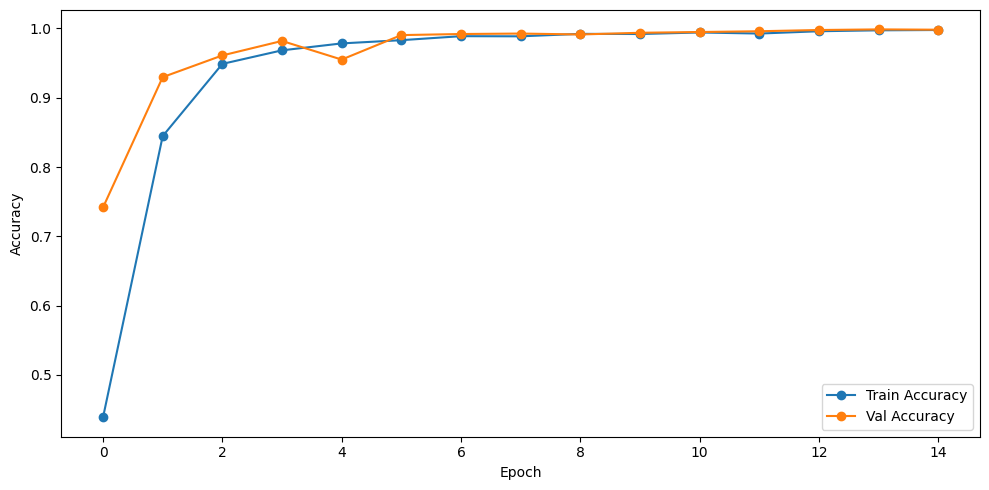

In [175]:
grafics(train_acc,val_acc, "Accuracy")          

#### Задание 2 (8 баллов + 4 бонусных). Генерация антител

Поиграем за B-лимфоцит и попробуем создать новые антитела.

Модель - почти полная копия модели с практики, но есть дополнительное условие: теперь кроме текущего токена и предыдущего скрытого состояния пусть наша ячейка принимает ещё метку биологического вида, к которому должно относиться антитело, вроде такого:

In [188]:
class ConditionalRNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}, c) -> h_{t}
    """
    def __init__(self, input_dim: int, class_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim + class_dim + hidden_dim, hidden_dim)

    def forward(self, x: Tensor, c: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim: эмбеддинг последнего токен
        # c: B x class_dim: эмбеддинг биологического вида
        # h: B x hidden_dim: последнее скрытое состояние
        h = torch.cat([x, c, h], dim=1)
        h = self.linear(h)
        return F.tanh(h)

In [177]:
class ConditionalGRUCell(nn.Module):
    """
    (x_{t}, h_{t-1}, c) -> h_{t}
    """
    def __init__(self, input_dim: int, class_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.W = nn.Linear(input_dim + class_dim + hidden_dim, hidden_dim)
        self.Wz = nn.Linear(input_dim + class_dim + hidden_dim, hidden_dim)
        self.Wr = nn.Linear(input_dim + class_dim + hidden_dim, hidden_dim)

    def forward(self, x: Tensor, c: Tensor, h: Tensor) -> Tensor:
       # x: B x input_dim: эмбеддинг последнего токен
        # c: B x class_dim: эмбеддинг биологического вида
        # h: B x hidden_dim: последнее скрытое состояние
        z_t = F.sigmoid(self.Wz(torch.cat([h, x, c], dim=1)))
        r_t = F.sigmoid(self.Wr(torch.cat([h, x, c], dim=1)))
        h_hat = F.tanh(self.W(torch.cat([r_t * h, x, c], dim=1)))
        return (1 - z_t) * h + z_t * h_hat

In [189]:

class GenRNN(nn.Module):
    def __init__(self, vocab_size: int = len(VOCAB), class_dim: int = len(SPECIES), hidden_dim: int = 64, cell: nn.Module = ConditionalRNNCell) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.embed_class = nn.Embedding(class_dim, hidden_dim // 8)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = cell(hidden_dim, hidden_dim // 8, hidden_dim)
        self.lm_head = nn.Linear(hidden_dim, vocab_size)


    def forward(self, x: Tensor, c: Tensor) -> Tensor:
        # x: B x T
        # embed(x): B x T -> B x T x hidden_dim
        B, T = x.shape

        x = self.embed(x)  # B x T x hidden_dim
        c = self.embed_class(c)
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        logits = [] # T x B x V
        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn.forward(xt, c, h)  # B x hidden
            y = self.lm_head(h).unsqueeze(1)  # B x 1 x hidden
            logits.append(y)
            # save prediction for step t + 1

        # lm_head: B x T x hidden -> B x T x V
        return torch.cat(logits, dim=1)



**2.1. (2 балла)** Реализуйте архитектуру модели для генерации антител символ за символом

**2.2. (2 балла)** Обучите модель в течение 10-50 эпох, постройте графики функции ошибки.

**2.3. (4 балла)** Сгенерируйте с помощью модели по 20 антител для каждого биологического вида в отдельных ячейках, выведите их в ноутбуке. Воспользуйтесь функцией `get_sequence_score` (ниже), чтобы посчитать сходство ваших антител с природными (вернее - очень грубую оценку). Посчитайте, сколько антител из сгенерированных вами имеют оценку 0.55 и выше для каждого биологического вида.

**2.4. (Бонус 4 балла)** Повторите пункты 2.2 и 2.3, но используйте другой тип рекуррентной ячейки (GRU или LSTM).


In [193]:
def train_epoch(dataloader: DataLoader,model: nn.Module,optimizer: torch.optim.Optimizer):
    model.train()
    loss_total = 0
    n_total = 0

    for tokens, labels in train_loader:
        logits = model(tokens.to(device), labels.to(device))  
        loss = F.cross_entropy(
            logits[:, :-1].reshape(-1, len(VOCAB)),
            tokens.to(device)[:, 1:].reshape(-1),
        )
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        n_total += labels.size(0)
        loss_total += labels.size(0) * loss.item()
        
    loss=loss_total / n_total
    train_loss.append(loss)

In [194]:
@torch.no_grad()
def test_epoch(dataloader: DataLoader,model: nn.Module):
    model.eval()
    loss_total = 0
    n_total = 0

    for tokens, labels in train_loader:
        logits = model(tokens.to(device), labels.to(device))  
        loss = F.cross_entropy(
            logits[:, :-1].reshape(-1, len(VOCAB)),
            tokens.to(device)[:, 1:].reshape(-1),
        )
        n_total += labels.size(0)
        loss_total += labels.size(0) * loss.item()
        
    loss=loss_total / n_total
    val_loss.append(loss)

In [195]:
torch.manual_seed(42)
model_rnn = GenRNN().to(device)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
EPOCHS = 15
train_loss = []
val_loss = []


for epoch in range(EPOCHS):
    print(f"EPOCH {epoch}")
    train_epoch(train_loader,model_rnn,optimizer) 
    test_epoch(test_loader,model_rnn)    
    print(f"Train: loss={train_loss[-1]:.5f};Val: loss={val_loss[-1]:.5f}")

EPOCH 0
Train: loss=2.29339;Val: loss=1.86373
EPOCH 1
Train: loss=1.62651;Val: loss=1.44681
EPOCH 2
Train: loss=1.35943;Val: loss=1.28287
EPOCH 3
Train: loss=1.23118;Val: loss=1.18270
EPOCH 4
Train: loss=1.15530;Val: loss=1.12643
EPOCH 5
Train: loss=1.10593;Val: loss=1.08769
EPOCH 6
Train: loss=1.07186;Val: loss=1.05686
EPOCH 7
Train: loss=1.04573;Val: loss=1.03622
EPOCH 8
Train: loss=1.02600;Val: loss=1.01325
EPOCH 9
Train: loss=1.00784;Val: loss=1.00004
EPOCH 10
Train: loss=0.99461;Val: loss=0.98579
EPOCH 11
Train: loss=0.98276;Val: loss=0.97385
EPOCH 12
Train: loss=0.97269;Val: loss=0.96895
EPOCH 13
Train: loss=0.96356;Val: loss=0.95752
EPOCH 14
Train: loss=0.95624;Val: loss=0.96129


RNNCell


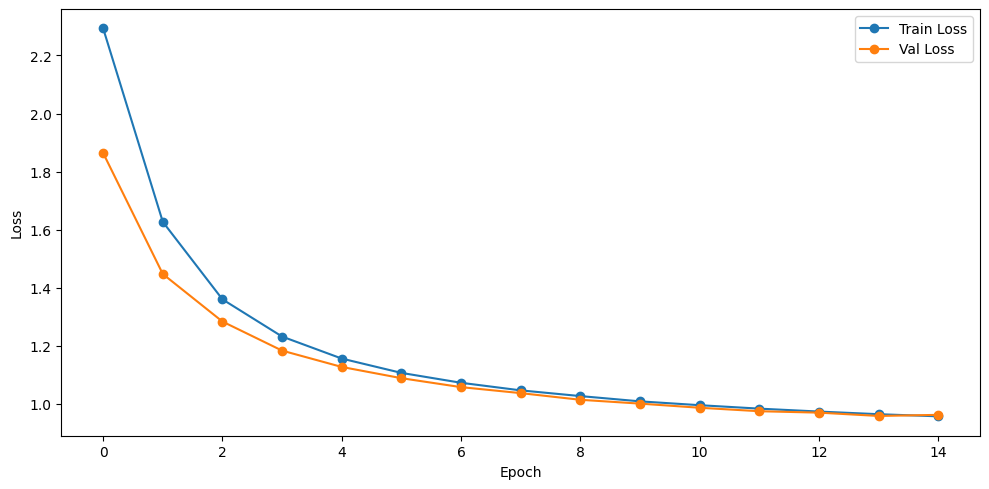

In [196]:
print('RNNCell')
grafics(train_loss, val_loss, "Loss")

In [200]:
torch.manual_seed(42)
model_gru = GenRNN(cell = ConditionalGRUCell).to(device)
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)
EPOCHS = 15
train_loss = []
val_loss = []


for epoch in range(EPOCHS):
    print(f"EPOCH {epoch}")
    train_epoch(train_loader,model_gru,optimizer) 
    test_epoch(test_loader,model_gru)    
    print(f"Train: loss={train_loss[-1]:.5f};Val: loss={val_loss[-1]:.5f}")

EPOCH 0
Train: loss=2.35536;Val: loss=1.89129
EPOCH 1
Train: loss=1.59831;Val: loss=1.36456
EPOCH 2
Train: loss=1.24769;Val: loss=1.14762
EPOCH 3
Train: loss=1.09369;Val: loss=1.04138
EPOCH 4
Train: loss=1.01239;Val: loss=0.97638
EPOCH 5
Train: loss=0.95881;Val: loss=0.93508
EPOCH 6
Train: loss=0.92396;Val: loss=0.90602
EPOCH 7
Train: loss=0.89719;Val: loss=0.88286
EPOCH 8
Train: loss=0.87931;Val: loss=0.86636
EPOCH 9
Train: loss=0.86245;Val: loss=0.85054
EPOCH 10
Train: loss=0.85077;Val: loss=0.84043
EPOCH 11
Train: loss=0.83978;Val: loss=0.83541
EPOCH 12
Train: loss=0.82992;Val: loss=0.82237
EPOCH 13
Train: loss=0.82571;Val: loss=0.81697
EPOCH 14
Train: loss=0.81727;Val: loss=0.80537


GRUCell


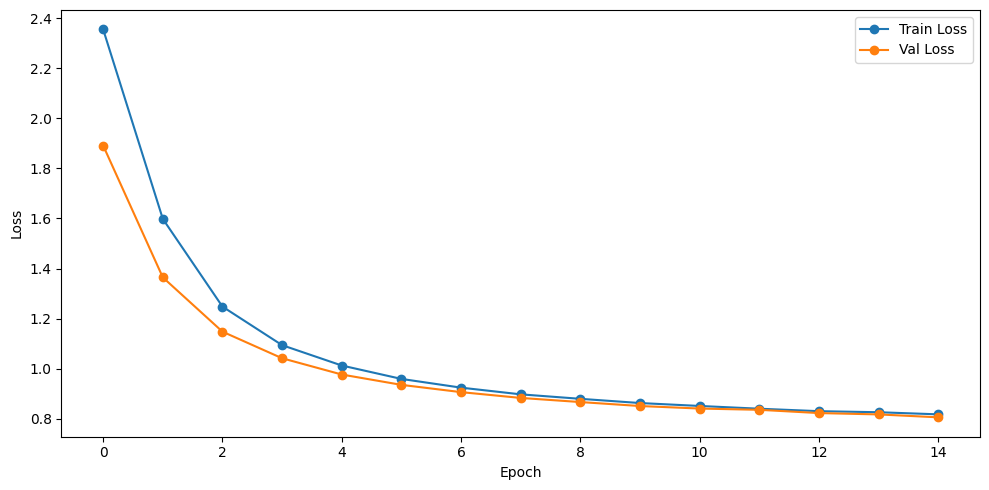

In [201]:
print('GRUCell')
grafics(train_loss, val_loss, "Loss")

In [231]:
@torch.no_grad()
def generate(model: RNN, max_new_tokens: int, species: dict[str, int] = SPECIES) -> Tensor:
    res = []
    for s in species:
        idx=torch.full(size=(20, 1), fill_value=1, dtype=int).to(device)
        for t in range(max_new_tokens):
            logits = model.forward(x=idx, c=torch.full(size=(20,), fill_value=species[s], dtype=int).to(device))[:, -1]  # B x T x V
            probs = F.softmax(logits, dim=1)  # B x V
            new_token = torch.multinomial(probs, 1)
            idx = torch.cat([idx, new_token], dim=1).to(device)

        res.append(idx)

    return torch.stack(res)

In [232]:
inverse_vocab = {VOCAB[key]: key for key in VOCAB}
def decode(species_out_tokens: Tensor) -> list[list[str]]:
    decoded_strings = []
    for s in species_out_tokens:
        species_decoded = []
        for x in s:
            species_decoded.append(''.join([inverse_vocab[c] if inverse_vocab[c] not in SPECIAL_TOKENS else '' for c in x.tolist()]))
        decoded_strings.append(species_decoded)

    return decoded_strings

In [236]:
torch.manual_seed(42)
samples_rnn = generate(model_rnn, max_new_tokens=133)
samples_gru = generate(model_gru, max_new_tokens=133)

In [237]:
decoded_rnn = decode(samples_rnn)
decoded_gru = decode(samples_gru) 

In [45]:
%pip install biopython==1.84

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 17.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [207]:
from Bio.Align import PairwiseAligner


def get_sequence_score(query_sequence: str) -> float:
    references = [
        "QVQLQQPGAELVKPGASVKMSCKAS_WITWVKQRPGQGLEWIGDI_TNYNEKFKTKATLTVDTSSSTAYMQLSSLTSEDSAVYYCAR_WGQGTSVTVSS",
        "EVKLEESGGGLVQPGGSMKLSCAAS_WMDWVRQSPEKGLEWVAEI_TYYAESVKGRFTISRDDSKSSVYLQMNSLRAEDTGIYYCTA_WGQGTLVTVSA",
        "HVQLVESGGGSVQPGGSLRLSCTVS_CMGWFRRAPGKEREKVATL_TSYADSVKGRFAISQDPAKNTLWLQMNSLKPEDSATYYCAA_SSRGTQVTVS",
        "QVQLVESGGGSVQAGGSLKLSCAAS_CMGWSRQAPGKGREGVARI_TAYADSVKGRFTISHDSIKNTLYLQMNSLRPEDTAKYYCAA_WGQGTQVTV",
        "QSLEESGGDLVKPGASLTLTCTAS_YMCWVRQAPGKGLEWIACI_TYYASWAKGRFTISKTSSTTVTLQMTSLTAADTATYFCAS_WGQGTLVTVS",
        "QEQLVESGGGLVKPGASLTLTCKAS_VMCWVRQAPGKGLEWIACI_SVYASWAKGRSTISRTSSTTVTLQMTSLTAADTATYFCAR_RGPGTLVTVS",
        "SVKVSCKAS_WIQWVRQAPGQGLEWMGWM_TTYSPKFQGRVSMTSDKSITTAYLELRGLTSDDTAVYSCAR_WGQGTLITVTS",
    ]
    max_score = 0.0
    for ref in map(lambda s: s.replace("_", ""), references):
        alignment = PairwiseAligner().align(query_sequence, ref)[0]
        n_matches = sum(
            1 for i in range(alignment.length) if alignment[0][i] == alignment[1][i]
        )
        max_score = max(max_score, n_matches / len(ref))

    return max_score

In [238]:
inverse_species = {SPECIES[key]: key for key in SPECIES}
def good_antibodies(decoded):
    for i in range(len(decoded)):
        species_cnt = 0
        for j in range(len(decoded[i])):
            species_cnt += 1 if len(decoded[i][j]) and get_sequence_score(decoded[i][j]) > 0.55 else 0
        print(inverse_species[i], species_cnt)
good_antibodies(decoded_rnn)

Camel 9
Human 9
Mouse 7
Rabbit 7
Rhesus 9


In [239]:
good_antibodies(decoded_gru)

Camel 13
Human 17
Mouse 18
Rabbit 14
Rhesus 19
